In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard


import numpy as np
from lstm_second import BasicLSTM
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\Spenc\Documents\GitHub\itcs-8156\utils')

from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

In [3]:

def makepred(model, dataset):
    y = []
    t = []
    for ii in dataset:
        feat, lab = ii

        y.append(model.forward(feat).detach().numpy()[0])
        t.append(lab.numpy()[0])


    return y, t

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

In [ ]:
actfn_labels = (['Sigmoid', 'ReLU', 'LeakyReLU', 'ELU', 'SELU', 'arcsinh', 'Swish', 'Softplus', 'Mish', 'Comb-H-Sine', 'tanh'])

results = []
for i in range(len(actfn_labels)):
    act1 = actfn_labels[i]

    for j in range(len(actfn_labels)):
        act2 = actfn_labels[j]
        display("Activation Function 1: ", act1)
        display("Activation Function 2: ", act2)
        mdl_stock = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01, actfn1=act1, actfn2=act2)
        mdl_stock.forward(ds_train[0][0])

        logger = TensorBoardLogger("lightning_logs", name="market")
        trainer = pl.Trainer(max_epochs=5,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
        trainer.fit(mdl_stock, train_dataloaders=dl_train)
        trainer.test(mdl_stock,dataloaders=dl_test)
        torch.save(mdl_stock, act1+act2)

        y_test, t_test = makepred(mdl_stock, ds_test)
        y_train, t_train = makepred(mdl_stock, ds_train)

        train_score = r2_score(t_train, y_train)
        test_score = r2_score(t_test, y_test)

        plt.figure()
        plt.plot(range(len(t_test)),t_test)
        plt.plot(range(len(y_test)),y_test)
        plt.title(act1+act2)

        add_res = [act1, act2, train_score, test_score]

        results.append(add_res)

display("Activation Fn 1, Activation Fn 2, Training R2, Testing R2")
display(results)
torch.save(results, 'ACT_FUNC_Results')

In [6]:
res = pd.DataFrame(torch.load('ACT_FUNC_Results'))
actfn_labels = (['Sigmoid', 'ReLU', 'LeakyReLU', 'ELU', 'SELU', 'arcsinh', 'Swish', 'Softplus', 'Mish', 'Comb-H-Sine', 'tanh'])
train_map = pd.DataFrame(np.zeros([len(actfn_labels),len(actfn_labels)]))
train_map.columns = actfn_labels
train_map.index = actfn_labels

test_map = pd.DataFrame(np.zeros([len(actfn_labels),len(actfn_labels)]))
test_map.columns = actfn_labels
test_map.index = actfn_labels

for i in range(len(actfn_labels)):
    actfn1 = actfn_labels[i]

    for j in range(len(actfn_labels)):
        actfn2 = actfn_labels[j]
        train_map.iloc[i,j] = res.where((res[0]==actfn1)).where(res[1]==actfn2)[2].dropna()
        test_map.iloc[i,j] = res.where((res[0]==actfn1)).where(res[1]==actfn2)[3].dropna()




In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
 
# All dataframes hereafter reflect these changes.
display(res.sort_values(3, ascending=False)) 
pd.reset_option('all')

C:\Users\Spenc\AppData\Local\Temp\ipykernel_30628\1665700425.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,0,1,2,3
44,SELU,Sigmoid,0.990917,0.999131
11,ReLU,Sigmoid,0.998423,0.998949
25,LeakyReLU,ELU,0.996809,0.996650
88,Mish,Sigmoid,0.989292,0.995260
65,arcsinh,tanh,0.992909,0.989306
51,SELU,Softplus,0.993462,0.986311
63,arcsinh,Mish,0.995547,0.986132
5,Sigmoid,arcsinh,0.993713,0.985447
95,Mish,Softplus,0.995875,0.984976
112,tanh,LeakyReLU,0.994723,0.984030


C:\Users\Spenc\AppData\Local\Temp\ipykernel_30628\1665700425.py:8: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
C:\Users\Spenc\AppData\Local\Temp\ipykernel_30628\1665700425.py:8: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
C:\Users\Spenc\AppData\Local\Temp\ipykernel_30628\1665700425.py:8: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


<Axes: >

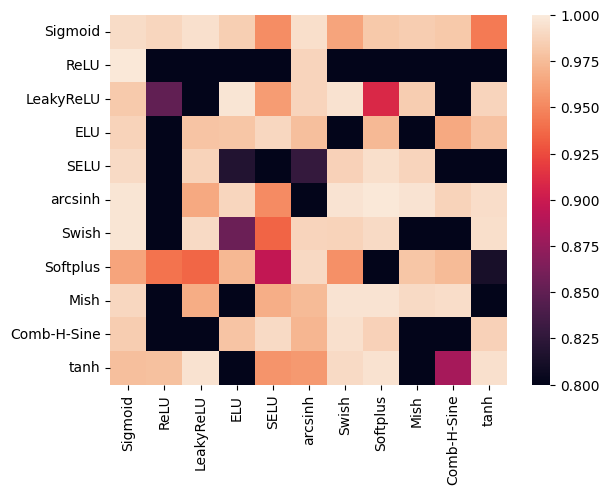

In [7]:
sns.heatmap(train_map, vmin=0.8, vmax=1)

<Axes: >

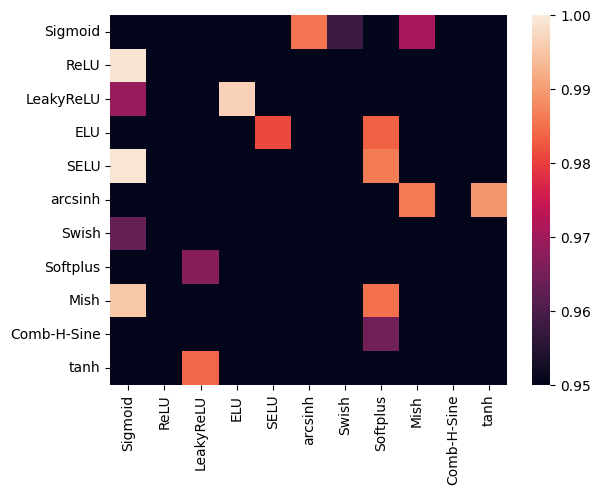

In [8]:
sns.heatmap(test_map, vmin=0.95, vmax=1)